# High and Low Temperatures from 2005 - 2015 in Houston, TX

Two NOAA datasets for Houston, TX have been stored in files Temps1.csv and Temps2.csv. The data come from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

The stations from which the data was collected are shown on the map below.

In [1]:
#NOAA files for my hometown of Houston, TX
files = ['Temps1.csv','Temps2.csv']

#Hash ids for the weather stations in Houston
Houston_hashids = ['9537599dfd3c61673f606db3e8d68438d270c4962e8676543df70603',
                   'dfa84ec2c23782e943422f54bc45af0a502ad3a36c199d2d0218876c']

In [6]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def get_stations(hashid):
    """This function finds all of the longitude and latitude coordinates from the NOAA 
    BinSize_d400.csv file of the weather stations by hash id."""
    
    df = pd.read_csv('BinSize_d400.csv')

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()
    
    return (lons, lats)

def leaflet_plot_stations(lons, lats):
    """This function plots the weather stations (given as longitude and latitude coordinates) on an interactive map."""

    plt.figure(figsize=(10,8))
    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

#Get all longitude and latitude coordinates from all files of interest
lons = []
lats = []

for i in range(len(Houston_hashids)):
    lons_temp = []
    lats_temp = []
    lons_temp, lats_temp = get_stations(Houston_hashids[i])
    lons.extend(lons_temp)
    lats.extend(lats_temp)

#Create a plot of all weather stations sampled
leaflet_plot_stations(lons, lats)

In [7]:
import matplotlib.pyplot as plt
% matplotlib notebook
import pandas as pd
import numpy as np

#Combining all Houston, TX temperature files into a single data frame

hou = pd.read_csv(files[0])
hou.append(pd.read_csv(files[1]))

#There are multiple TMAX and TMIN values for each date corresponding to different station IDs
#These have been averaged together to give a single max and single min value per date

hou_group = hou.groupby(['Date', 'Element'], as_index = False).agg({'Data_Value' : ['mean']})
hou_group.columns = hou_group.columns.droplevel(1)

#Function to remove the year from all the dates
def noyear(df):
    """This function creates a new column to save the original date string, and removes the year from the date string
    in the 'Date' column."""
    
    df["FullDate"] = df.Date
    for i in range(len(df.Date)):
        df.Date[i] = df.Date[i][5:]
    return df

#Feb 29th is removed from the data
hou_group = noyear(hou_group)
hou_group.drop(list(np.where(hou_group["Date"] == "02-29")[0]), inplace = True)
hou_group.reset_index(inplace = True, drop = True)

C:\Users\Julie\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
#Function to get Maxs and Mins data for any year
def get_max_or_min_data(df_original, minmax, start_date = 0, end_date = 0):
    df = df_original.where(df_original.Element == minmax).dropna()
    
    if start_date == 0:
        df.reset_index(inplace = True, drop = True)
        return df
    
    start = list(np.where(df["FullDate"] == start_date)[0])[0]
    end = list(np.where(df["FullDate"] == end_date)[0])[0]
    
    df.drop(df.index[:start], inplace = True)
    df.drop(df.index[end:], inplace = True)
    df.reset_index(inplace = True, drop = True)
    return df

#Function to get record temperatures, either maxes or minimums
def get_record_temps(df_original, fx = 'mean'):
    df = df_original.groupby(['Date'], as_index = False).agg({"Data_Value": fx})
    df.reset_index(inplace = True, drop = True)
    return df

#Function for converting Date strings to datetime objects
def str_to_date(df, dateformat = '%m-%d'):
    from datetime import datetime as dt
    dates = []
    for i in range(len(df.Date)):
        dates.append(dt.strptime(df.Date[i], dateformat))
    return dates

In [9]:
### PART 1: Get mean min and max temperature data across all years (2005 - 2015) for plotting

#Get max and min data for all years
hou_max = get_max_or_min_data(hou_group, minmax = "TMAX")
hou_min = get_max_or_min_data(hou_group, minmax = "TMIN")

#Get the mean and SD of the max and min temperatures for Houston for each day of the year
hou_recordmax = get_record_temps(hou_max, 'mean')
hou_recordmin = get_record_temps(hou_min, 'mean')

### PART 2: Find record breaking temps in 2015

#Get max and min data for 2015
hou_max2015 = get_max_or_min_data(hou_group, 
                                  minmax = "TMAX", 
                                  start_date = "2015-01-01", 
                                  end_date = "2015-12-31")

hou_min2015 = get_max_or_min_data(hou_group, 
                                  minmax = "TMIN", 
                                  start_date = "2015-01-01", 
                                  end_date = "2015-12-31")

#Get the standard deviation of max and min temps
hou_recordmax_SD = get_record_temps(hou_max, 'std')
hou_recordmin_SD = get_record_temps(hou_min, 'std')

In [11]:
#Determine which max and min temperatures in 2015 were 1 standard deviations above/below average
#This will be the "record breaking" 2015 data for the plot

#Function to find temperatures a certain number of SD above/below average maxes and mins
def record_breaking_temps(df_yr, df_mean, df_sd, numstd = 1, minmax = "Max"):
    
    df_yr = df_yr.copy()
    if minmax == "Max":
        df_yr["RecBreak"] = df_yr.Data_Value > (df_mean.Data_Value+(numstd*df_sd.Data_Value))
    else:
        df_yr["RecBreak"] = df_yr.Data_Value < (df_mean.Data_Value-(numstd*df_sd.Data_Value))
    scatter = df_yr.where(df_yr.RecBreak == True).dropna()
    scatter.reset_index(inplace = True, drop = True)
    dates_scatter = str_to_date(scatter)
    
    return scatter, dates_scatter

#2015 Record breaking temps using 1SD
max_scatter, dates_max_scatter = record_breaking_temps(hou_max2015, hou_recordmax, hou_recordmax_SD,
                                                      numstd = 1, minmax = "Max")

min_scatter, dates_min_scatter = record_breaking_temps(hou_min2015, hou_recordmin, hou_recordmin_SD,
                                                      numstd = 1, minmax = "Min")

#2015 Record breaking temps using 2SD
max_scatter2, dates_max_scatter2 = record_breaking_temps(hou_max2015, hou_recordmax, hou_recordmax_SD,
                                                      numstd = 2, minmax = "Max")

min_scatter2, dates_min_scatter2 = record_breaking_temps(hou_min2015, hou_recordmin, hou_recordmin_SD,
                                                      numstd = 2, minmax = "Min")


<IPython.core.display.Javascript object>


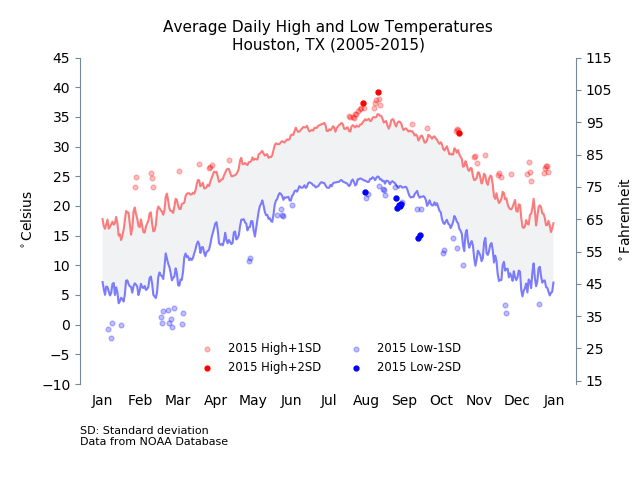

In [12]:
### PART 3: Plotting the Data
dates = str_to_date(hou_recordmax)

#Creating the initial figure
plt.figure()
plt.gcf().subplots_adjust(bottom=0.2)
plt.plot(dates, hou_recordmax.Data_Value/10, "-", color = 'red', alpha = 0.5, label='_nolegend_')
plt.plot(dates, hou_recordmin.Data_Value/10, '-', color = 'blue', alpha = 0.5, label='_nolegend_')

#Shading the area between the lines
plt.gca().fill_between(dates, 
                       hou_recordmax.Data_Value/10, 
                       hou_recordmin.Data_Value/10,
                      facecolor = 'lightslategrey',
                      alpha = 0.1,
                      label='_nolegend_')

#Plotting maximum temperatures
plt.scatter(dates_max_scatter, 
            max_scatter.Data_Value/10, s=12 , 
            color = 'red', alpha = 0.25, label = "Max")

plt.scatter(dates_max_scatter2, 
            max_scatter2.Data_Value/10, s=12 , 
            color = 'red', alpha = 1, label = "Max")

#Plotting minimum temperatures
plt.scatter(dates_min_scatter, 
            min_scatter.Data_Value/10, s=12 , 
            color = 'blue', alpha = 0.25, label = "Min")

plt.scatter(dates_min_scatter2, 
            min_scatter2.Data_Value/10, s=12 , 
            color = 'blue', alpha = 1, label = "Min")



### PART 4 - Making the Figure Look Nice
ax = plt.gca()

#Setting x-axis ticks to month labels
locs, labels = plt.xticks()

import calendar
month_labels = []
for i in range(1,13):
    month_labels.append(calendar.month_name[i][0:3])

month_labels.append(month_labels[0])

plt.xticks(np.arange(locs[0],
                     (locs[-1]+((locs[-1]-locs[0])/12)),
                     ((locs[-1]-locs[0])/12)), month_labels, rotation=0)

#Setting the y-axis and creating labels
ax.axis(ymin = -10, ymax = 45)
plt.yticks(np.arange(-10,46,5))

# Hide borders, remove ticks, create labels, legend, title
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_color('lightslategrey')
ax.tick_params(bottom=False, color = 'lightslategrey')
plt.ylabel("$^\circ$Celsius")
plt.legend(['2015 High+1SD', '2015 High+2SD', '2015 Low-1SD', '2015 Low-2SD'], ncol = 2, 
           fontsize = 'small', loc = 8, frameon = False)
ax.set_title("Average Daily High and Low Temperatures\nHouston, TX (2005-2015)", fontsize = 11)

#Create a second y-axis on the right for Fahrenheit
ax2 = ax.twinx()
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['right'].set_color('lightslategrey')
ax2.tick_params(bottom=False, color = 'lightslategrey')
ax2.axis(ymin = 14, ymax = 113)
plt.yticks(np.arange(15,116,10))
plt.ylabel("$^\circ$Fahrenheit")

#Add clarifying note at the bottom defining SD and noting the data source
plt.annotate('SD: Standard deviation\nData from NOAA Database', 
             (0,0), (0, -30), fontsize = 8,
             xycoords='axes fraction', textcoords='offset points', va='top')

#Save the figure and create downloadable link
image = 'Houston_Temps.png'
plt.savefig(image)
from IPython.display import HTML
HTML('<a href ="{0}" download>Click here to download {0}</a>'.format(image))